# Init

In [16]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [503]:
import itertools, os; import pandas as pd; import numpy  as np
from pandas.tseries.offsets import *
import statsmodels.formula.api as smf;
import seaborn as sns
pd.options.display.float_format = '{:,.2f}'.format

sns.set( 'notebook', style="white", rc={"lines.linewidth": 2.0})

In [504]:
%%html
<style>
table:not(.dataframe) {float:left; font-size:120% !important;}
</style>

# Definition

| Quantity | Formula $\qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad\quad\quad$ |
|:----------|:----------|
| Share volume on day $t$            | $ V_t $ |
| Position as of day $t$, in shares  | $ X_t = \sum_{s=0}^t V_t$ |
| Dollar volume on day $t$ | $ D_t $ |
| Cost of position as of day $t$, in dollars | $ Y_t = \sum_{s=0}^t D_t$ |
| CRSP stock price | $P_t$ |
| Mark-to-market value | $ M_t = X_t P_t $ |
| Capital at risk | $ A_t = \max_{t} \mid Y_t \mid $ |
| Cumulative percentage profit | $\text{Pro}_t = \frac{M_t - Y_t}{A_t} $
| Daily percentage profit | $R_t = \frac{1+\text{Pro}_t}{1+\text{Pro}_{t-1}} - 1 $

In [505]:
def compute_profits(te):
    te['D'] = te['V'] * te['XP']
    te['X'] = te['V'].cumsum()
    te['Y'] = te['D'].cumsum()

    te['M'  ] = te['X'] * te['P']
    te[['M_L', 'D_L', 'Y_L']] = te[['M', 'D', 'Y']].shift(1).fillna(0)
    te['A'  ] = (te['D'] + te['M_L']).abs()
    te['A'  ] = np.where( te['A'] > te['M_L'].abs(), (te['M_L'] + te['D']).abs(), te['M_L'].abs() )
    te[['A_L']] = te[['A']].shift(1)
    
    te['ret'] = te['P'].pct_change().fillna(0) 
    te['cum'] = (te['ret'] + 1).cumprod() - 1

    #te['R'  ] = (( te['M'] - te['M_L'] - te['D'] ) / te['A']).fillna(0)    
    #te['Profit'] = (te['R'] + 1).cumprod() - 1
    #te['Profit'] = ( ( np.where(te['X']>0,1,-1) * np.where(te['X']>0, 
    #    1+te['R']/100, 
    #    1-te['R']/100
    #) ) .cumprod() - 1 ) * 100
    
    # New way
    te['pro'] = te['M'] - te['Y']
    te['A'  ] = te['Y'].abs().max()
    te['Pro'] = te['pro'] / te['A']
    te['R'  ] = (1+te['Pro']).pct_change().fillna(0)
    
    return te

def plot_profits(te, title='Example', print_stats=False):
    
    te = te.copy()
    te['Pro'] *= 100
    fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,6))
    ax3 = ax1.twinx()
    
    if te['Pro'].mean() > 0: col = 'g'
    else                   : col = 'r'
        
    te['P'  ].plot(marker='o', ax=ax1, linestyle='-')
    
    te['V+'] = te['V'] * (te['V']>0)
    te['V+'].plot(kind='bar', color='g', alpha=0.5)
    te['V-'] = te['V'] * (te['V']<0)
    te['V-'].plot(kind='bar', color='r', alpha=0.5)
    
    ax2.fill_between( te.index, 0, te['Pro'], color=col, alpha=0.3 )
    te['Pro'].plot(marker='o', ax=ax2, color=col    );
    
    ax1.legend(frameon=True, loc=3);
    ax2.legend(frameon=True, loc=4);
    
    if print_stats:
        print("Total profit  : {0:1.0f} $".format( te.iloc[-1]['M']-te.iloc[-1]['Y'] ))
        print("Max   exposure: {0:1.0f} $".format( te['Y'].abs().max() ))
        print("Rough return  : {0:1.0f} %".format( (te.iloc[-1]['M']-te.iloc[-1]['Y']) / te['Y'].abs().max() * 100 ))
    
    ax2.set_ylim([-50, 50])
    ax3.set_ylim([-15, 15])
    #ax2.axhline(0, linestyle=':', color='k')
    
    ax1.set_title(title); 
    ax3.yaxis.set_label_text("Share Volume" ); 
    ax1.yaxis.set_label_text("Price" ); 
    ax2.yaxis.set_label_text("Profit (%)");
    plt.tight_layout();
    
    display(te[['V', 'X', 'D', 'Y', 'P', 'M', 'A', 'Pro', 'R']])

In [506]:
te = pd.DataFrame({
    'XP': [10 ,   9,   7  ,   6.7,  8      ],
    'P' : [10 ,   8,   6.4,  7.04,  8.448  ],
}, index=range(5))

# Examples

## Example
This trader closes the position and switches to a long one at the lowest price ($t=2$). He fully exploits the price reversal

,V,X,D,Y,P,M,A,Pro,R
0,-3,-3,-30.00,-30.00,10.00,-30.00,48.00,0.00,0.00
1,-2,-5,-18.00,-48.00,8.00,-40.00,48.00,16.67,0.17
2,10,5,70.00,22.00,6.40,32.00,48.00,20.83,0.04
3,2,7,13.40,35.40,7.04,49.28,48.00,28.92,0.07
4,-7,0,-56.00,-20.60,8.45,0.00,48.00,42.92,0.11


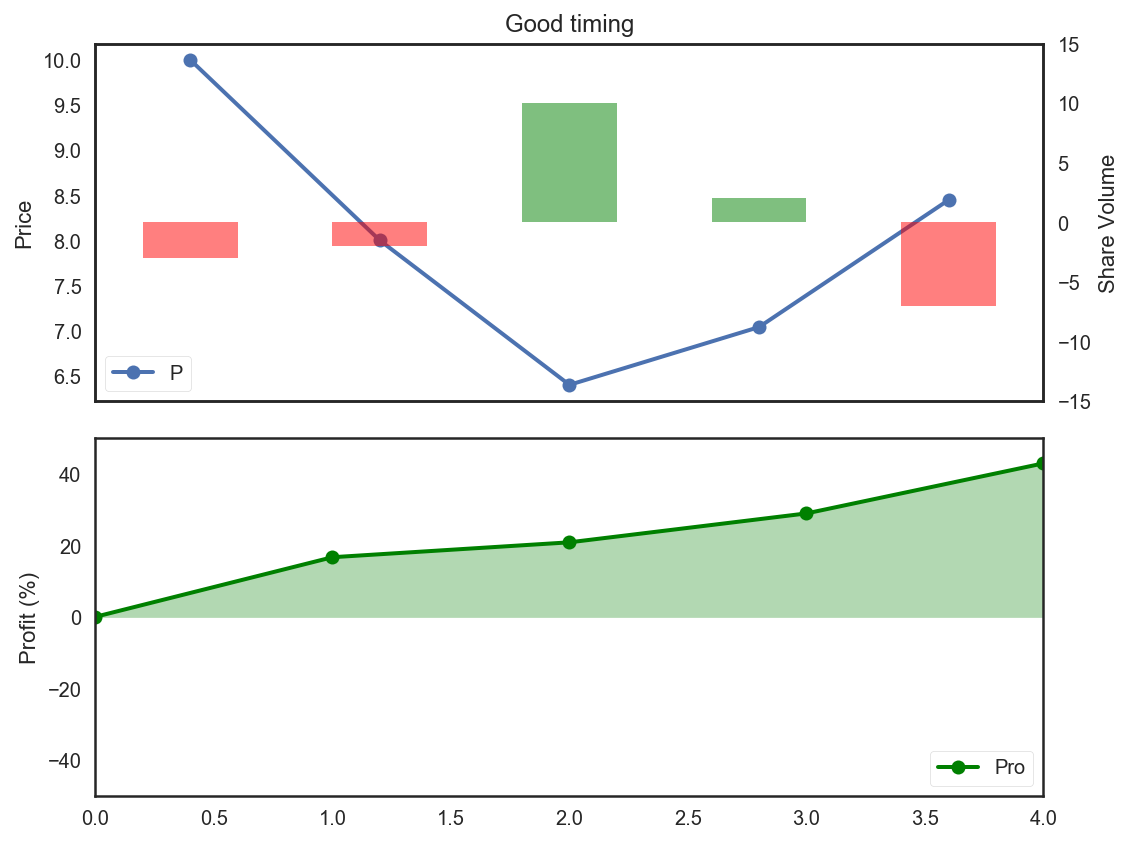

In [507]:
te['V'] = [ -3 , -2,  10,  2,  -7  ]
plot_profits(compute_profits(te), "Good timing")

## Example
Keep or unwind?

,V,X,D,Y,P,M,A,Pro,R
0,5,5,50.00,50.00,10.00,50.00,50.00,0.00,0.00
1,0,5,0.00,50.00,8.00,40.00,50.00,-20.00,-0.20
2,0,5,0.00,50.00,6.40,32.00,50.00,-36.00,-0.20
3,0,5,0.00,50.00,7.04,35.20,50.00,-29.60,0.10
4,0,5,0.00,50.00,8.45,42.24,50.00,-15.52,0.20


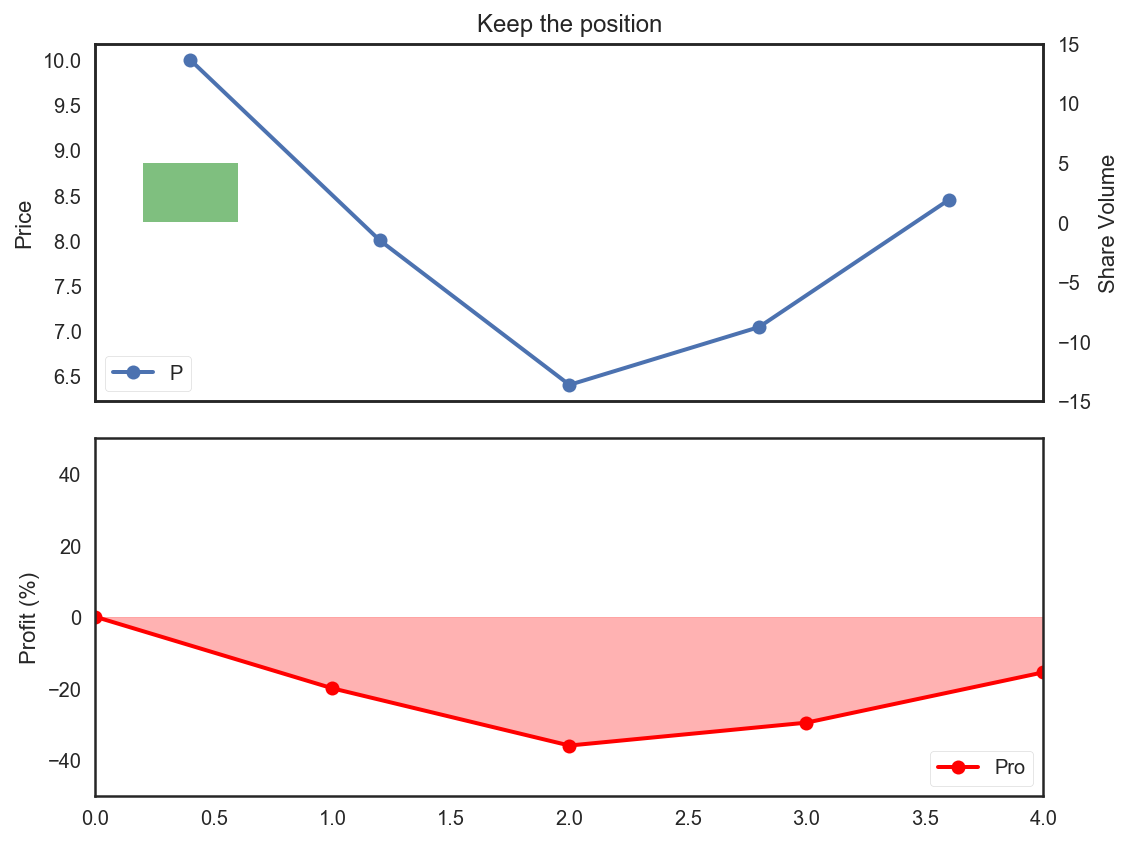

In [508]:
te['V'] = [ 5 , 0, 0, 0, 0 ]
plot_profits(compute_profits(te), title="Keep the position")

,V,X,D,Y,P,M,A,Pro,R
0,5,5,50.00,50.00,10.00,50.00,50.00,0.00,0.00
1,-3,2,-27.00,23.00,8.00,16.00,50.00,-14.00,-0.14
2,0,2,0.00,23.00,6.40,12.80,50.00,-20.40,-0.07
3,0,2,0.00,23.00,7.04,14.08,50.00,-17.84,0.03
4,0,2,0.00,23.00,8.45,16.90,50.00,-12.21,0.07


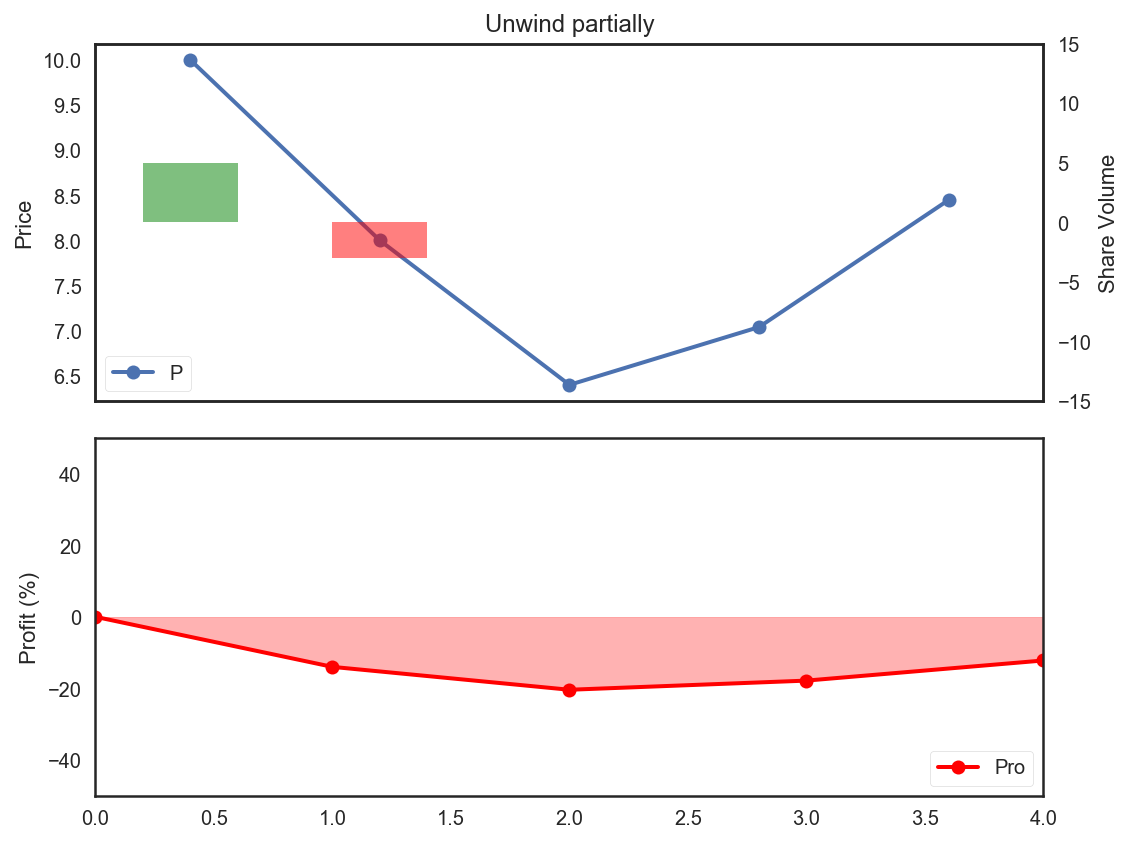

In [509]:
te['V'] = [ 5 , -3, 0, 0, 0 ]
plot_profits(compute_profits(te), title="Unwind partially")

,V,X,D,Y,P,M,A,Pro,R
0,5,5,50.00,50.00,10.00,50.00,50.00,0.00,0.00
1,-5,0,-45.00,5.00,8.00,0.00,50.00,-10.00,-0.10
2,0,0,0.00,5.00,6.40,0.00,50.00,-10.00,0.00
3,0,0,0.00,5.00,7.04,0.00,50.00,-10.00,0.00
4,0,0,0.00,5.00,8.45,0.00,50.00,-10.00,0.00


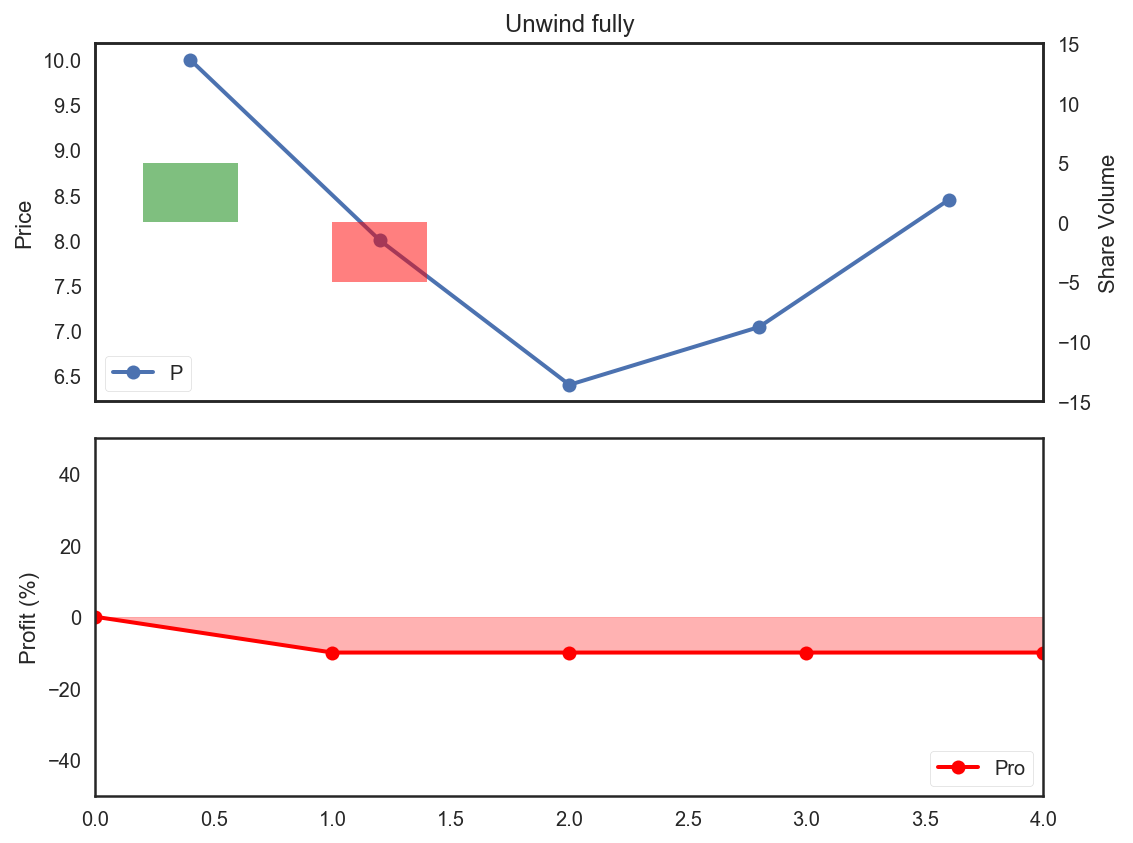

In [510]:
te['V'] = [ 5 , -5, 0, 0, 0 ]
plot_profits(compute_profits(te), title="Unwind fully")

,V,X,D,Y,P,M,A,Pro,R
0,5,5,50.00,50.00,10.00,50.00,50.00,0.00,0.00
1,0,5,0.00,50.00,8.00,40.00,50.00,-20.00,-0.20
2,-5,0,-35.00,15.00,6.40,0.00,50.00,-30.00,-0.13
3,0,0,0.00,15.00,7.04,0.00,50.00,-30.00,0.00
4,0,0,0.00,15.00,8.45,0.00,50.00,-30.00,0.00


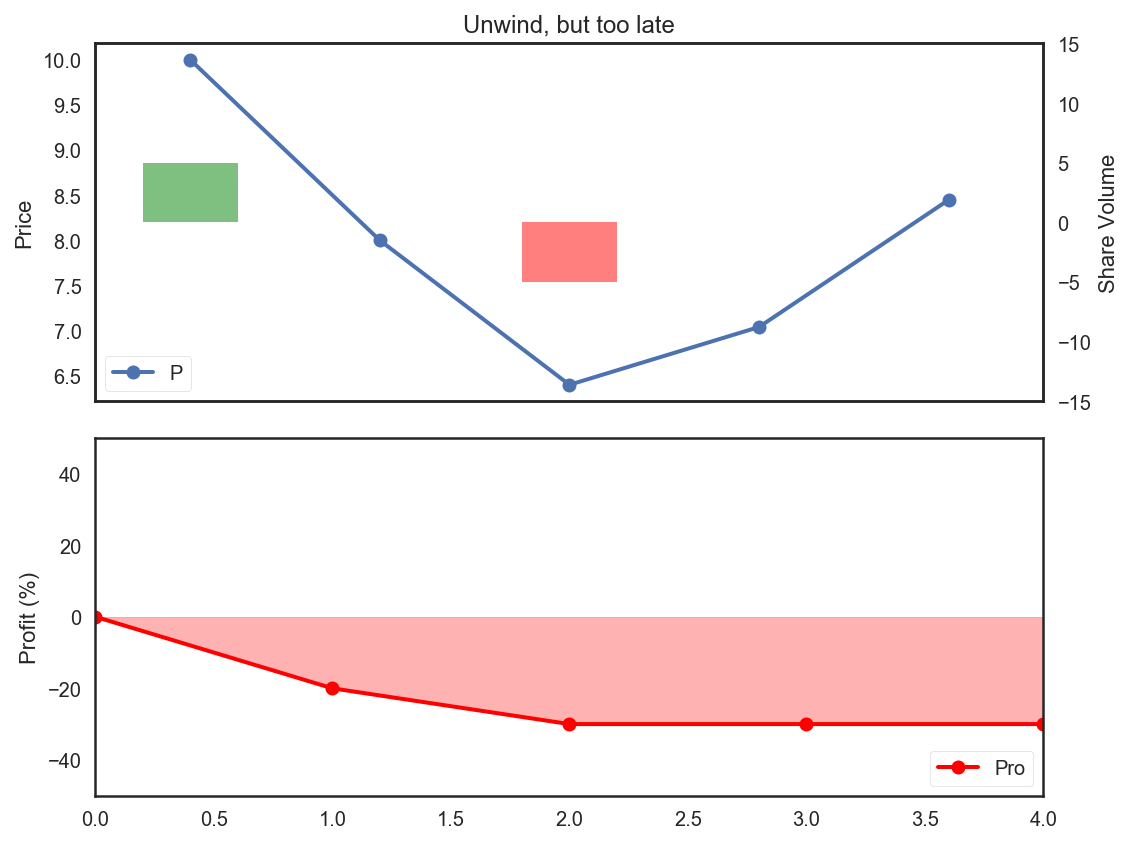

In [511]:
te['V'] = [ 5 , 0, -5, 0, 0 ]
plot_profits(compute_profits(te), title="Unwind, but too late")

## Example
Short and then cover

,V,X,D,Y,P,M,A,Pro,R
0,-5,-5,-50.00,-50.00,10.00,-50.00,50.00,0.00,0.00
1,5,0,45.00,-5.00,8.00,0.00,50.00,10.00,0.10
2,0,0,0.00,-5.00,6.40,0.00,50.00,10.00,0.00
3,0,0,0.00,-5.00,7.04,0.00,50.00,10.00,0.00
4,0,0,0.00,-5.00,8.45,0.00,50.00,10.00,0.00


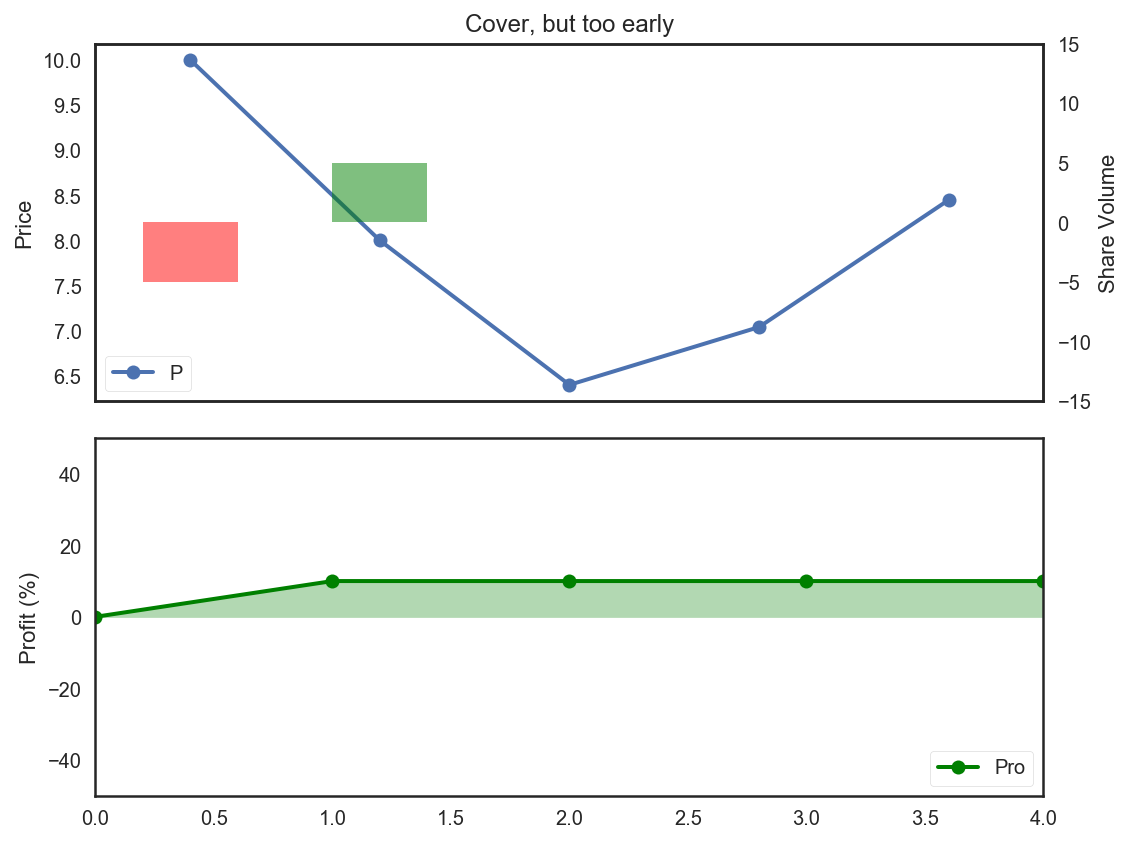

In [512]:
te['V'] = [ -5 , 5, 0, 0, 0 ]
plot_profits(compute_profits(te), title="Cover, but too early")

,V,X,D,Y,P,M,A,Pro,R
0,-5,-5,-50.00,-50.00,10.00,-50.00,50.00,0.00,0.00
1,0,-5,0.00,-50.00,8.00,-40.00,50.00,20.00,0.20
2,5,0,35.00,-15.00,6.40,0.00,50.00,30.00,0.08
3,0,0,0.00,-15.00,7.04,0.00,50.00,30.00,0.00
4,0,0,0.00,-15.00,8.45,0.00,50.00,30.00,0.00


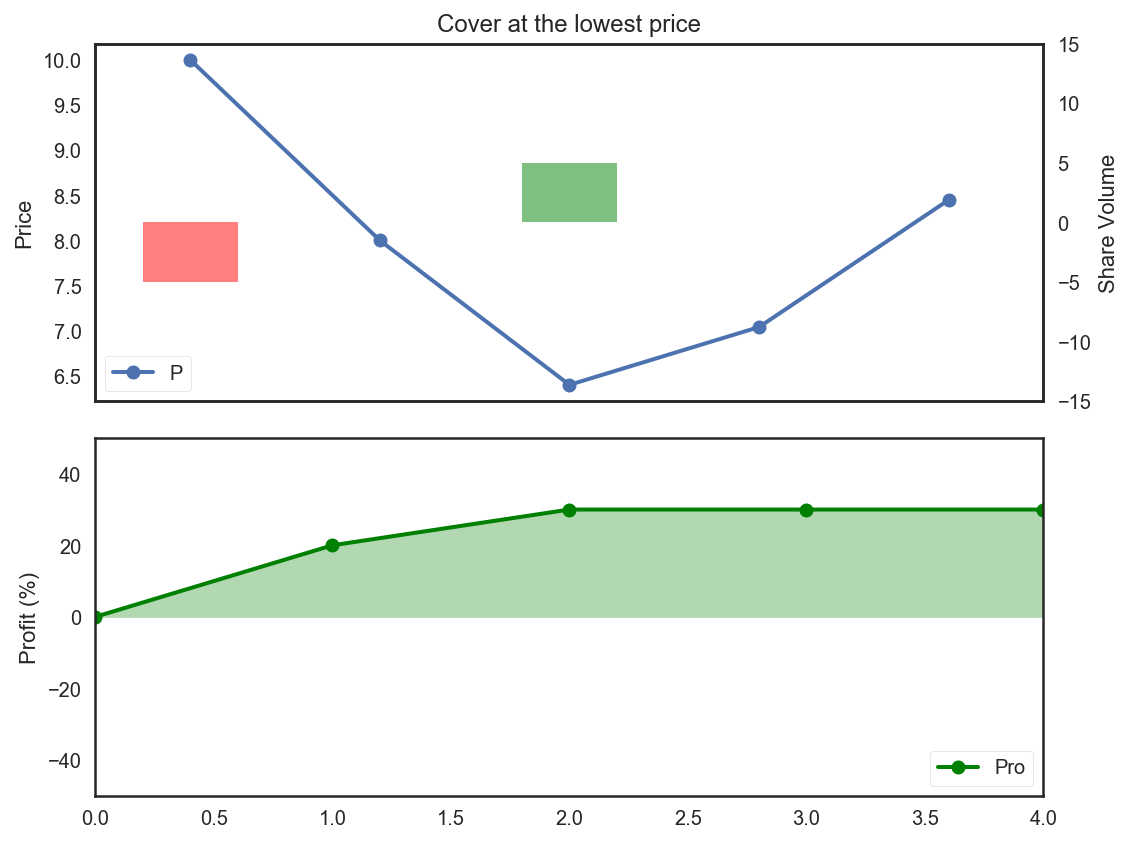

In [513]:
te['V'] = [-5, 0, 5, 0, 0 ]
plot_profits(compute_profits(te), title="Cover at the lowest price")

,V,X,D,Y,P,M,A,Pro,R
0,-5,-5,-50.00,-50.00,10.00,-50.00,50.00,0.00,0.00
1,0,-5,0.00,-50.00,8.00,-40.00,50.00,20.00,0.20
2,0,-5,0.00,-50.00,6.40,-32.00,50.00,36.00,0.13
3,5,0,33.50,-16.50,7.04,0.00,50.00,33.00,-0.02
4,0,0,0.00,-16.50,8.45,0.00,50.00,33.00,0.00


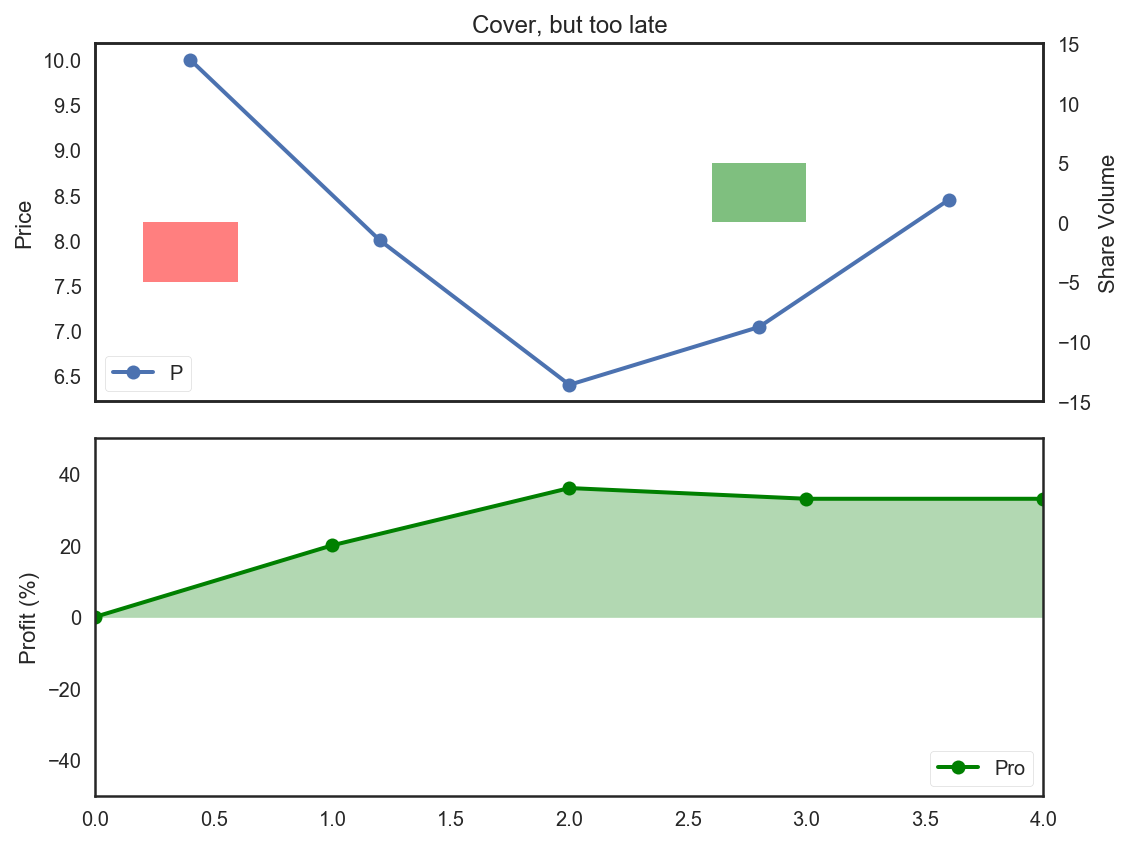

In [514]:
te['V'] = [-5 , 0, 0, 5, 0 ]
plot_profits(compute_profits(te), title="Cover, but too late")

## Example

,V,X,D,Y,P,M,A,Pro,R
0,-3,-3,-30.00,-30.00,10.00,-30.00,48.00,0.00,0.00
1,-2,-5,-18.00,-48.00,8.00,-40.00,48.00,16.67,0.17
2,7,2,49.00,1.00,6.40,12.80,48.00,24.58,0.07
3,3,5,20.10,21.10,7.04,35.20,48.00,29.38,0.04
4,-8,-3,-64.00,-42.90,8.45,-25.34,48.00,36.57,0.06


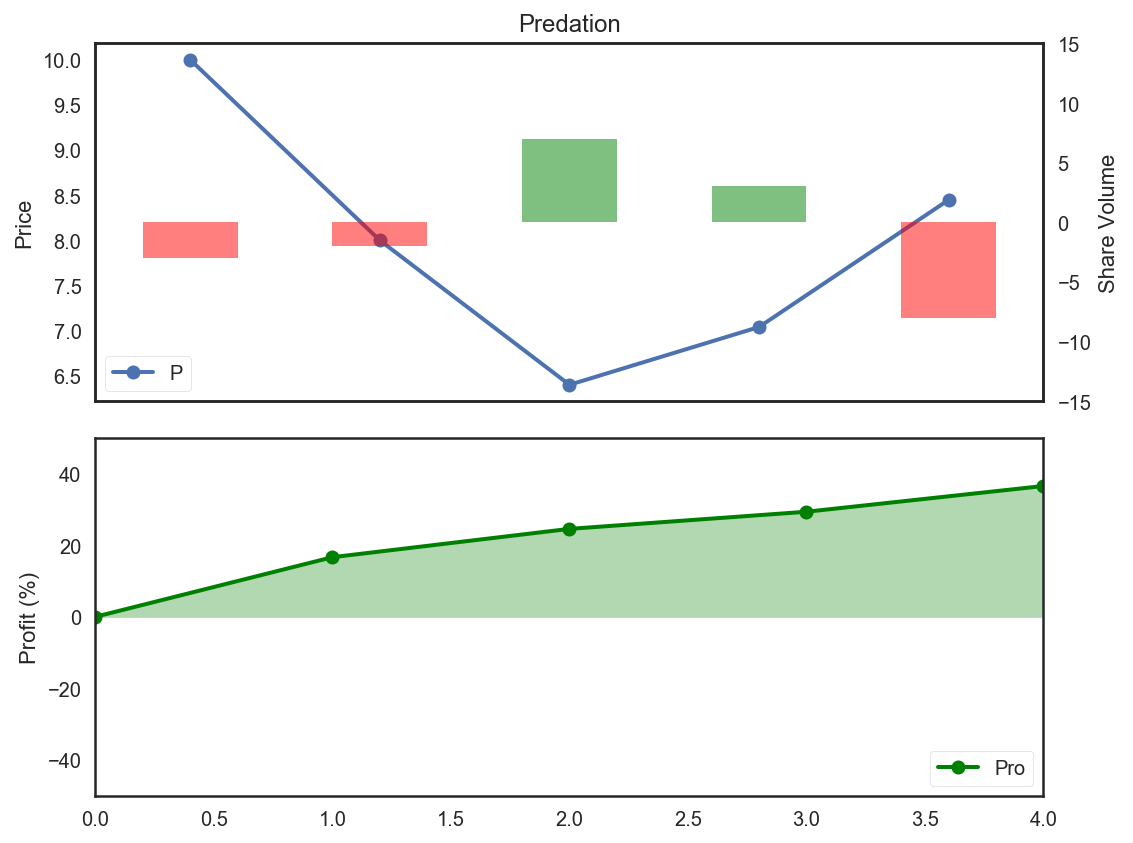

In [515]:
te['V'] = [ -3,   -2,     7,     3,  -8  ]
plot_profits(compute_profits(te), "Predation")

,V,X,D,Y,P,M,A,Pro,R
0,-3,-3,-30.00,-30.00,10.00,-30.00,76.20,0.00,0.00
1,-2,-5,-18.00,-48.00,8.00,-40.00,76.20,10.50,0.10
2,12,7,84.00,36.00,6.40,44.80,76.20,11.55,0.01
3,6,13,40.20,76.20,7.04,91.52,76.20,20.10,0.08
4,-13,0,-104.00,-27.80,8.45,0.00,76.20,36.48,0.14


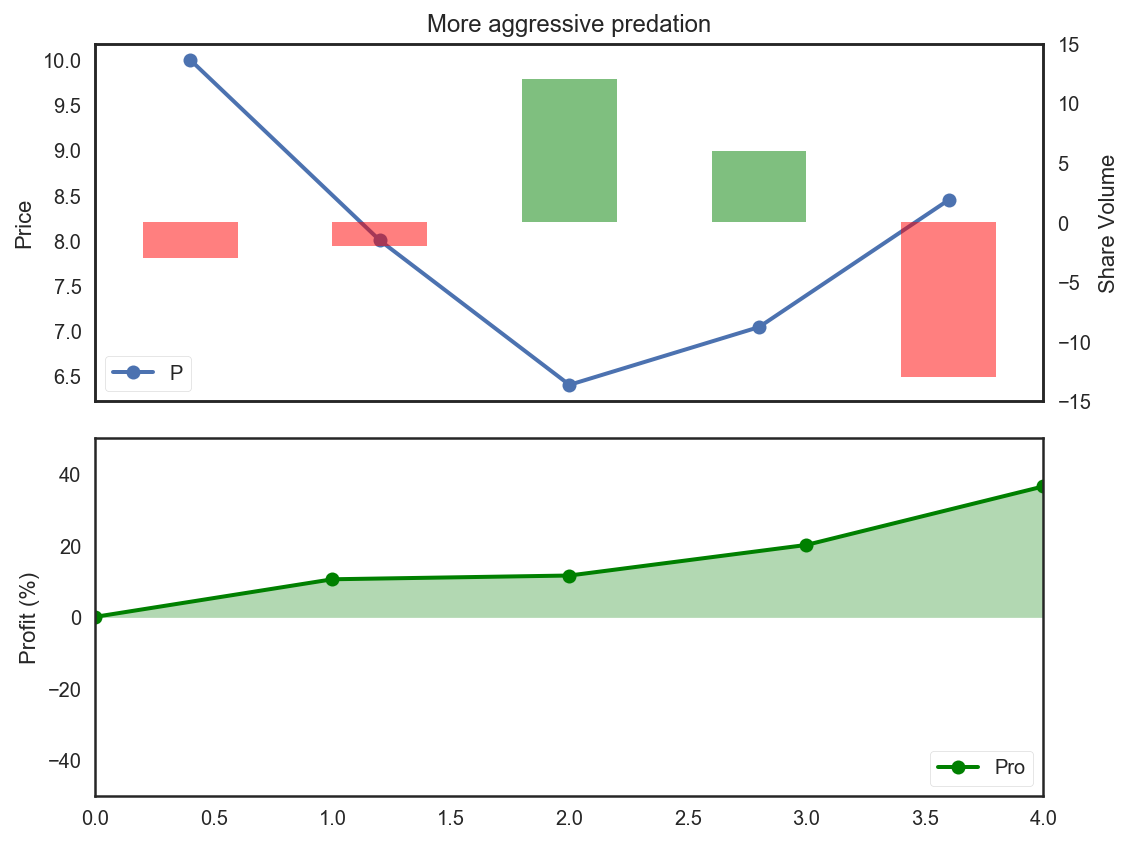

In [516]:
te['V'] = [ -3,   -2,     12,     6,  -13    ]
plot_profits(compute_profits(te), "More aggressive predation")

<br/><br/><br/><br/>